## Exploratory Data Analysis Preceding LDA
#### CAPP 30254

Author: Nivedita Vatsa

In [27]:
import pandas as pd
import gensim
import re
from mask_keywords import keywords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer # MIGHT REMOVE
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

import gensim 
from gensim import corpora, models

### 1. Import consolidated data

In [2]:
df_orig = pd.read_csv("../data/dailies/full_tweets.csv") # untouched by cleaning steps
df_orig = df_orig[['date', 'text']]

df = pd.read_csv("../data/dailies/full_tweets.csv")
df = df[['date', 'text']]

In [3]:
# amp = df[df['text'].str.contains('amp')==True]
# list(amp['text'])

### 2. Clean text

Cleaning steps involve:
+ removing websites
+ removing Twitter 'mentions'
+ removing Twitter hashtags
+ removing punctuation and special characters
+ remove words with numbers, with a few exceptions (e.g., covid-19, n-95, etc)
+ removing stop words (from **nltk**)
+ lemmatize (using **SpaCy**)

In [4]:
# # lemmatize with nltk
# def lemmatize_nltk(text):
#     '''
#     '''
#     stemmer = WordNetLemmatizer()
#     text = text.split() # DO NOT USE SPLIT
#     text = [stemmer.lemmatize(word) for word in text if len(word) > 3]
#     return text

In [5]:
# lemmatize with SpaCy
nlp = spacy.load("en_core_web_sm")
def lemmatize(text):
    '''
    '''
    doc = nlp(text)
    words = []
    for token in doc:
        words.append(token.lemma_)
    return ' '.join(words)

In [6]:
def clean_tweets(text):
    '''
    Clean the text of tweets
    '''
    text = re.sub(r"http\S+", "", text) # websites
    text = re.sub(r"www.\S+", "", text)
    text = re.sub("@[a-z0-9_]+", " ", text) # mentions
    text = re.sub("#[a-z0-9_]+","", text) # hashtags
    text = re.sub("[^a-z0-9 ]", "", text) # special characters
    
    # remove words with numbers, but with exceptions
    do_not_discard = ['covid19', 'n95', 'kn95', 'sarscov2', 'c19', 'cov19']
    clean_w = [] 
    for w in text.split():
        if w not in do_not_discard:
            w = re.sub("\w*\d\w*", "", w) # token with number in it
        clean_w.append(w)
    text = " ".join(clean_w)
    
    # lemmatize
    text = lemmatize(text)
    return text

In [7]:
# apply text processing steps to the text field
df['text'] = df.apply(lambda row : clean_tweets(row['text']), axis = 1)

### 3. Document Term Matrix

In [8]:
cv = CountVectorizer(stop_words = stopwords.words('english') + ['amp'], min_df = 5)
data_cv = cv.fit_transform(df['text'])
dtm = pd.DataFrame(data_cv.todense(), columns = cv.get_feature_names_out())
dtm.index = df.index

In [9]:
def get_era(df, dtm, start, end):
    '''
    Subset dataframe using date range
    '''
    return list(df.index[(df['date'] >= start) & (df['date'] <= end)])

def get_freq(dtm_subset, ignore_words):
    '''
    Get a dictionary of tokens and their corresponding count
    for a given document-term-matrix
    '''
    freq = dtm_subset.sum(axis = 0)
    freq = freq.sort_values(ascending = False).to_dict()
    tmp = [freq.pop(key) for key in ignore_words if key in freq]
    return freq

def get_freq_by_era(df, dtm, start, end, ignore_words):
    '''
    '''
    era_idx = get_era(df, dtm, start, end)
    dtm_subset = dtm.iloc[era_idx, : ]
    return get_freq(dtm_subset, ignore_words)


def get_freq_by_kw(df, dtm, keyword, ignore_words):
    '''
    '''
    kw_idx = list(df.index[df['text'].str.contains(keyword)==True])
    dtm_subset = dtm.iloc[kw_idx, : ]
    return get_freq(dtm_subset, ignore_words)


### 4. Word Cloud: Find Top Terms by Period

In [10]:
wordcloud_ignore = keywords + ['covid19', 'coronavirus', 'face', 'wear', 'people']

##### 4a. Onset of the pandemic

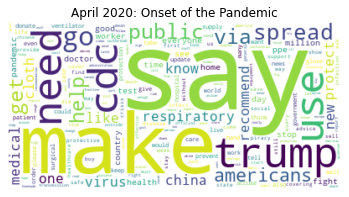

In [11]:
era = get_freq_by_era(df, dtm,'2020-04-03', '2020-04-06', wordcloud_ignore)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(era)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("April 2020: Onset of the Pandemic")
plt.show()

In [ ]:
# MAKE
# note that we're filtering 'df_orig' using criteria on 'df'
tmp = df_orig.loc[(df['date'] >= '2020-04-03') & (df['date'] <= '2020-04-06') & df['text'].str.contains('make')==True]
for row in tmp.itertuples():
    #print("~~~")
    #print(row[2])

In [14]:
# SAY
# note that we're filtering 'df_orig' using criteria on 'df'
tmp = df_orig.loc[(df['date'] >= '2020-04-03') & (df['date'] <= '2020-04-06') & df['text'].str.contains('say')==True]
say_dict = {}
for row in tmp.itertuples():
    words = row[2].split()
    for idx, w in enumerate(words):
        if w and ((w == 'say') or ('say' in w)) and idx >= 1:
            word_before = words[idx - 1]        
            say_dict[word_before] = say_dict.get(word_before, 0) + 1

sorted(say_dict.items(), key=lambda x: x[1], reverse=True)

[('cdc', 91),
 ('trump', 62),
 ('to', 12),
 ('now', 8),
 ('experts', 6),
 ('official', 5),
 ('they', 5),
 ('officials', 5),
 ('is', 5),
 ('photo', 5),
 ('nurse', 5),
 ("masks'", 5),
 ('masks’', 5),
 ('biden', 5),
 ('patients', 4),
 ('who', 4),
 ('scientists', 3),
 ('was', 3),
 ('researchers', 3),
 ('just', 3),
 ('scientist', 3),
 ('trudeau', 3),
 ('but', 3),
 ('were', 2),
 ('after', 2),
 ('expert', 2),
 ('by', 2),
 ('\u2066@realdonaldtrump\u2069', 2),
 ('and', 2),
 ('that', 2),
 ('he', 2),
 ('pm', 2),
 ('can’t', 2),
 ('bay,', 2),
 ('research', 2),
 ('study', 2),
 ('china', 2),
 ('like', 1),
 ("i'd", 1),
 ('officer', 1),
 ('coronavirus', 1),
 ('unions', 1),
 ('cook', 1),
 ('#fco', 1),
 ("they're", 1),
 ('always', 1),
 ('nurses', 1),
 ('should', 1),
 ('sources', 1),
 ('not', 1),
 ('believe', 1),
 ('man', 1),
 ('covered', 1),
 ('again,', 1),
 ('wuhan', 1),
 ('are', 1),
 ('coronavirus,', 1),
 ('mistake,’', 1),
 ('#cdc', 1),
 ('it,"', 1),
 ('guys', 1),
 ('kelly', 1),
 ('dunno...just', 1),
 

##### 4b. CDC study finds masking to be a preventive factor

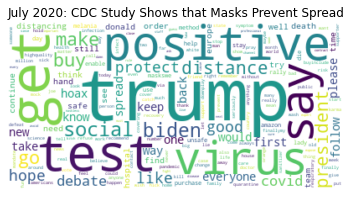

In [15]:
era = get_freq_by_era(df, dtm,'2020-09-29', '2020-10-02', wordcloud_ignore)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(era)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("July 2020: CDC Study Shows that Masks Prevent Spread")
plt.show()

##### 4c. Presidential Debate & Donald Trump Tests Positive for COVID-19

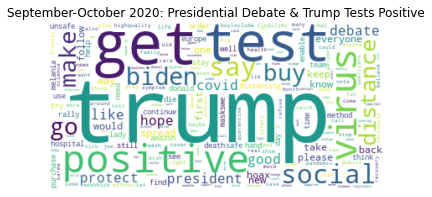

In [16]:
era = get_freq_by_era(df, dtm,'2020-09-29', '2020-10-02', wordcloud_ignore)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(era)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("September-October 2020: Presidential Debate & Trump Tests Positive")
plt.show()

##### 4d. 2020 Presidential Election

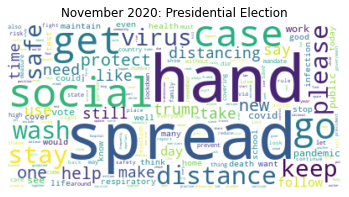

In [17]:
era = get_freq_by_era(df, dtm,'2020-11-03', '2020-11-05', wordcloud_ignore)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(era)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("November 2020: Presidential Election")
plt.show()

##### 4e. Biden is Sworn In & Signs Executive Order Requiring Masks

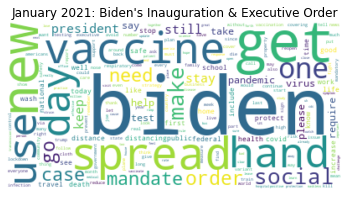

In [18]:
era = get_freq_by_era(df, dtm,'2021-01-20', '2021-01-21', wordcloud_ignore)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(era)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("January 2021: Biden's Inauguration & Executive Order")
plt.show()

##### 4f. Judge Lifts Biden Executive Order on Masking

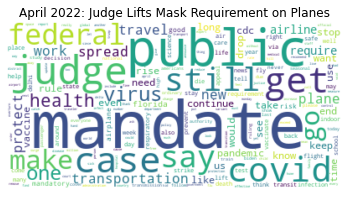

In [19]:
era = get_freq_by_era(df, dtm,'2022-04-18', '2022-04-21', wordcloud_ignore)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(era)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("April 2022: Judge Lifts Mask Requirement on Planes")
plt.show()

##### 4g. Overall

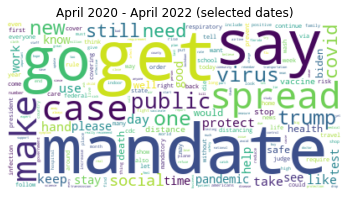

In [20]:
era = get_freq_by_era(df, dtm,'2020-04-01', '2022-05-01', wordcloud_ignore)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(era)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("April 2020 - April 2022 (selected dates)")
plt.show()

### 5. Word Cloud by Topic

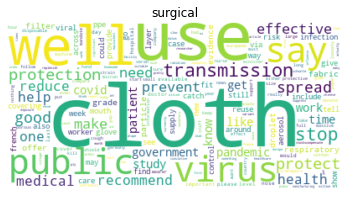

In [21]:
kw = 'surgical'
kw_freq= get_freq_by_kw(df, dtm, kw, wordcloud_ignore + [kw])
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(kw_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(kw)
plt.show()

### 6. LDA

In [ ]:
document = df[["text"]]
processed_data = []
for row in document.values:
    text = row[0]
    tokens = text.split()
    #tokens = pre_process(text, stopwords)
    for t in tokens:
        if t not in keywords + stopwords.words('english') + ['amp']:
            processed_data.append(tokens)


input_dict = corpora.Dictionary(processed_data)
input_corpus = [input_dict.doc2bow(token, allow_update=True) for token in processed_data]
lda_model = gensim.models.ldamodel.LdaModel(input_corpus, num_topics=4, id2word=input_dict, passes=20)
topics = lda_model.print_topics(num_words=10)

for t in topics:
    print(t)

#### Throwaway

In [ ]:
# demonstration (to delete):
print("~~~~")
a1 = "covid-19"
print("EXAMPLE 1")
print("ORIGINAL:", a1)
print("OPTION 1:", re.sub(r"[^a-zA-Z]",' ', a1))
print("OPTION 2:", re.sub("[^a-z0-9 ]", "", a1))

print("~~~~")
a2 = 'n-95 masks protect against sars-cov-2'
print("EXAMPLE 2")
print("ORIGINAL:", a2)
print("OPTION 1:", re.sub(r"[^a-zA-Z]",' ', a2))
print("OPTION 2:", re.sub("[^a-z0-9 ]", "", a2))